# Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

## Análisis exploratorio

Inspeccionar datos: columnas, tipos, valores nulos, estadísticas generales.

Analizar:

- Distribución de la duración de llamadas.

- Cantidad de llamadas por dirección (in, out) e internas/externas.

- Evolución del número de llamadas por día.

- Identificar operadores más y menos activos.



In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [194]:
#Estilo de graficos
sns.set_style("whitegrid")
corporate_palette = ['#1f3b73', '#a7a9ac']

In [195]:
# Cargamos el dataset
df_clients = pd.read_csv ('telecom_clients_us.csv')
df_calls =pd.read_csv ('telecom_dataset_us.csv')

In [196]:
#Primer vistazo a los datos
clients_info = df_clients.info()
calls_info = df_calls.info()

print(clients_info)

print(calls_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 

In [197]:
#Datos estadisticos generales
clients_desc = df_clients.describe()
calls_desc = df_calls.describe()

print(clients_desc)

print(calls_desc)

             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000
             user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.0000

In [198]:
#Visualizamos los datos de los datasets
clients_head = df_clients.head()
calls_head = df_calls.head()

clients_head, calls_head  

(   user_id tariff_plan  date_start
 0   166713           A  2019-08-15
 1   166901           A  2019-08-23
 2   168527           A  2019-10-29
 3   167097           A  2019-09-01
 4   168193           A  2019-10-16,
    user_id                       date direction internal  operator_id  \
 0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
 1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
 2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
 
    is_missed_call  calls_count  call_duration  total_call_duration  
 0            True            2              0                    4  
 1            True            3              0                    5  
 2            True            1              0                    1  
 3           False            1             10           

### Concluciones
- Limpiar o imputar los nulos en internal y operator_id.

- Procesar las fechas (date_start y date) como datetime.

- Analizar separadamente las llamadas internas y externas.

- Segmentar las llamadas entrantes perdidas.

In [199]:
#Convertimos las columnas de fecha a tipo datetime
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])
df_calls['date'] = pd.to_datetime(df_calls['date'])

print(df_clients.info())
print()
print(df_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64          

In [200]:
df_calls['internal'] = df_calls['internal'].astype(bool)

In [201]:
#Verificamos valores nulos
nulls_calls = df_calls.isnull().sum()
nulls_calls

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [202]:
#Para `internal` rellenamos con False asumiendo que son externas
df_calls['internal'] = df_calls['internal'].fillna(False)

#Para `operator_id` rellenamos con -1 para indicar llamadas sin operador
df_calls['operator_id'] = df_calls['operator_id'].fillna(-1).astype(int)



In [203]:
#Creamos una nueva columna: tiempo de espera = total_call_duration - call_duration
df_calls['waiting_time'] = df_calls['total_call_duration'] - df_calls['call_duration']

#Creamos una nueva columna: duracion de llamadas en minutos
df_calls['call_duration_min'] = round(df_calls['call_duration'] / 60)

df_calls.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,call_duration_min
21044,167016,2019-11-03 00:00:00+03:00,in,False,-1,True,18,0,154,154,0.0
11329,166691,2019-10-05 00:00:00+03:00,in,False,-1,True,1,0,74,74,0.0
36131,167580,2019-10-31 00:00:00+03:00,out,False,936382,True,6,0,267,267,0.0
31920,167445,2019-11-18 00:00:00+03:00,out,False,920732,False,13,1385,1546,161,23.0
13918,166812,2019-10-17 00:00:00+03:00,in,False,900594,False,1,35,47,12,1.0
41232,167828,2019-11-26 00:00:00+03:00,in,False,940440,False,2,193,212,19,3.0
45691,168064,2019-10-21 00:00:00+03:00,out,False,939762,True,1,0,26,26,0.0
35459,167532,2019-10-21 00:00:00+03:00,out,False,917856,False,3,339,351,12,6.0
6728,166582,2019-08-31 00:00:00+03:00,out,False,885890,False,116,10095,12260,2165,168.0
35221,167521,2019-11-24 00:00:00+03:00,in,False,961770,False,7,283,354,71,5.0


### Total llamadas por dirección (in vs out)

C:\Users\Te Amo\AppData\Local\Temp\ipykernel_20296\603846101.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=direction_counts, x='direction', y='calls_count', palette=corporate_palette)


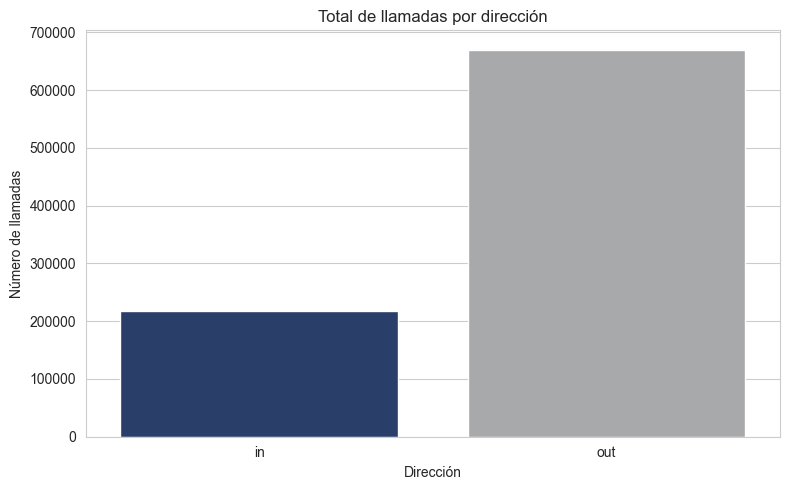

In [204]:
# Agrupación
direction_counts = df_calls.groupby('direction')['calls_count'].sum().reset_index()

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=direction_counts, x='direction', y='calls_count', palette=corporate_palette)
plt.title('Total de llamadas por dirección')
plt.ylabel('Número de llamadas')
plt.xlabel('Dirección')
plt.tight_layout()
plt.show()

## Duración promedio de llamadas por dirección

C:\Users\Te Amo\AppData\Local\Temp\ipykernel_20296\4191578717.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_call_duration_min, x='direction', y='call_duration_min', palette=corporate_palette)


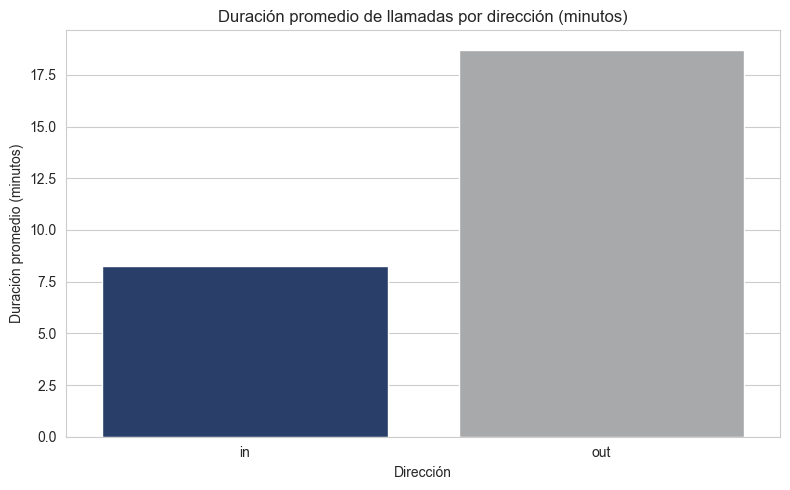

In [205]:
# Agrupación por dirección para duración promedio
avg_call_duration = df_calls.groupby('direction')['call_duration'].mean().reset_index()

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_call_duration_min, x='direction', y='call_duration_min', palette=corporate_palette)
plt.title('Duración promedio de llamadas por dirección (minutos)')
plt.ylabel('Duración promedio (minutos)')
plt.xlabel('Dirección')
plt.tight_layout()
plt.show()

### Top 10 operadores con más llamadas perdidas

In [206]:
#Filtramos los datos 
top  = df_calls[df_calls['operator_id']!=-1]

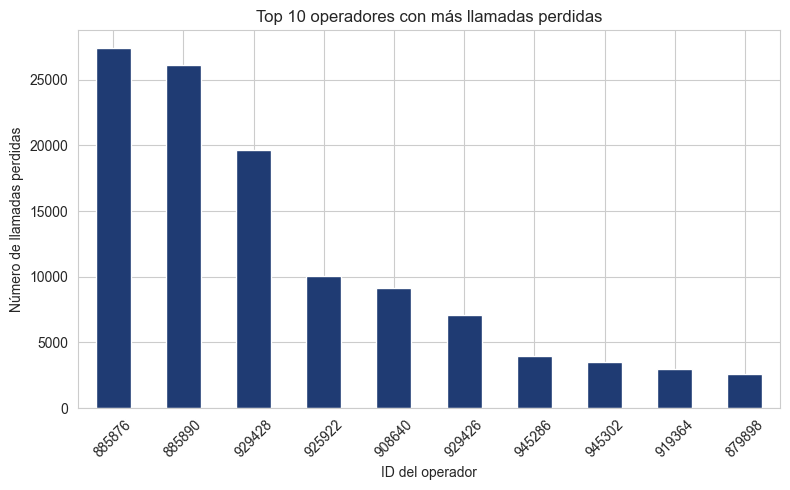

In [207]:

# Filtrado de llamadas perdidas
missed_calls = top[top['is_missed_call'] == True]



# Agrupación por operador y selección del top 10
missed_per_operator = (
    missed_calls.groupby('operator_id')['calls_count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Gráfico
plt.figure(figsize=(8, 5))
missed_per_operator.plot(kind='bar', color=corporate_palette[0])
plt.title('Top 10 operadores con más llamadas perdidas')
plt.ylabel('Número de llamadas perdidas')
plt.xlabel('ID del operador')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identificar Operadores Ineficaces

- Tiene muchas llamadas entrantes perdidas `(is_missed_call = True y direction = 'in')`.

- Tiene mucho tiempo de espera `(waiting_time alto) en llamadas entrantes`.

- Si hace llamadas salientes `(direction = 'out'), realiza pocas llamadas`.

In [208]:
#Filtramos solo registros con operadores asignados
df_calls_valid = df_calls[df_calls['operator_id']!=-1]

df_calls_valid

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,call_duration_min
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5,0.0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1,0.0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8,0.0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25,0.0
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26,0.0
...,...,...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,25,0.0
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,38,0.0
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,22,8.0
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,60,52.0


### Indicadores para cada operador

In [209]:
# Llamadas entrantes
entrantes = df_calls_valid[df_calls_valid['direction'] == 'in']
entrantes

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,call_duration_min
26,166377,2019-08-12 00:00:00+03:00,in,False,880028,False,1,407,411,4,7.0
34,166377,2019-08-13 00:00:00+03:00,in,False,880028,False,1,88,102,14,1.0
37,166377,2019-08-14 00:00:00+03:00,in,False,880026,False,2,197,218,21,3.0
39,166377,2019-08-14 00:00:00+03:00,in,False,880028,False,1,33,37,4,1.0
49,166377,2019-08-15 00:00:00+03:00,in,False,880028,False,1,23,27,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
53872,168601,2019-11-26 00:00:00+03:00,in,False,952914,False,4,539,562,23,9.0
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914,False,4,539,562,23,9.0
53877,168601,2019-11-27 00:00:00+03:00,in,False,952914,False,2,53,77,24,1.0
53891,168606,2019-11-08 00:00:00+03:00,in,False,957922,True,1,0,7,7,0.0


In [210]:
#Agrupamos por operador
operator_in_metrics = entrantes.groupby('operator_id').agg(
    total_in_calls =('calls_count','sum'),
    missed_in_calls = ('is_missed_call', lambda x:(x * 1).sum()),
    avg_waiting_time = ('waiting_time', 'mean'),
).reset_index()

operator_in_metrics

,operator_id,total_in_calls,missed_in_calls,avg_waiting_time
0,879896,60,0,26.913043
1,879898,118,0,28.203125
2,880020,8,0,7.250000
3,880022,8,0,14.000000
4,880026,25,0,7.894737
...,...,...,...,...
749,971102,78,0,274.000000
750,971354,6,0,42.000000
751,972412,1,0,25.000000
752,972460,2,0,4.000000


In [211]:
#Calculamos porcentaje de llamadas perdidas
operator_in_metrics['missed_call_rate'] = (operator_in_metrics['missed_in_calls'] / operator_in_metrics['total_in_calls'] * 100).round(2)

operator_in_metrics

,operator_id,total_in_calls,missed_in_calls,avg_waiting_time,missed_call_rate
0,879896,60,0,26.913043,0.0
1,879898,118,0,28.203125,0.0
2,880020,8,0,7.250000,0.0
3,880022,8,0,14.000000,0.0
4,880026,25,0,7.894737,0.0
...,...,...,...,...,...
749,971102,78,0,274.000000,0.0
750,971354,6,0,42.000000,0.0
751,972412,1,0,25.000000,0.0
752,972460,2,0,4.000000,0.0


In [212]:
# Para llamadas salientes
salientes = df_calls_valid[df_calls_valid['direction'] == 'out']

salientes

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,call_duration_min
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5,0.0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1,0.0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8,0.0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25,0.0
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26,0.0
...,...,...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,25,0.0
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,38,0.0
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,22,8.0
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,60,52.0


In [213]:
#Agrupamos por operador

operator_out_metrics = salientes.groupby('operator_id').agg(
    total_out_calls = ('calls_count', 'sum')
).reset_index()

operator_out_metrics

,operator_id,total_out_calls
0,879896,1071
1,879898,7856
2,880020,46
3,880022,211
4,880026,2414
...,...,...
877,972408,8
878,972410,77
879,972412,60
880,972460,68


In [214]:
#Unimos los datasets
operator_metrics = pd.merge(
    operator_in_metrics,
    operator_out_metrics,
    on='operator_id',
    how='outer'
)

operator_metrics

,operator_id,total_in_calls,missed_in_calls,avg_waiting_time,missed_call_rate,total_out_calls
0,879896,60.0,0.0,26.913043,0.0,1071.0
1,879898,118.0,0.0,28.203125,0.0,7856.0
2,880020,8.0,0.0,7.250000,0.0,46.0
3,880022,8.0,0.0,14.000000,0.0,211.0
4,880026,25.0,0.0,7.894737,0.0,2414.0
...,...,...,...,...,...,...
1087,972410,NaN,NaN,NaN,NaN,77.0
1088,972412,1.0,0.0,25.000000,0.0,60.0
1089,972460,2.0,0.0,4.000000,0.0,68.0
1090,973120,NaN,NaN,NaN,NaN,3.0


In [215]:
# Llenamos NaN en total_out_calls con 0
operator_metrics['total_out_calls'] = operator_metrics['total_out_calls'].fillna(0).astype(int)
operator_metrics

,operator_id,total_in_calls,missed_in_calls,avg_waiting_time,missed_call_rate,total_out_calls
0,879896,60.0,0.0,26.913043,0.0,1071
1,879898,118.0,0.0,28.203125,0.0,7856
2,880020,8.0,0.0,7.250000,0.0,46
3,880022,8.0,0.0,14.000000,0.0,211
4,880026,25.0,0.0,7.894737,0.0,2414
...,...,...,...,...,...,...
1087,972410,NaN,NaN,NaN,NaN,77
1088,972412,1.0,0.0,25.000000,0.0,60
1089,972460,2.0,0.0,4.000000,0.0,68
1090,973120,NaN,NaN,NaN,NaN,3


### Definimos umbrales para identificar operadores ineficases

| Métrica            | Condición de ineficacia       | Cómo lo calcularemos                        |
|:-------------------|:------------------------------|:--------------------------------------------|
| Missed call rate   | Muy alto (los peores)         | Operadores por arriba del 75 percentil      |
| Tiempo de espera   | Muy alto (los peores)         | Operadores por arriba del 75 percentil      |
| Total out calls    | Muy bajo (los menos activos)  | Operadores por debajo del 25 percentil      |

¿Por qué?

- 75% percentile significa: operadores que tienen más tiempo de espera o más llamadas perdidas que el 75% de los demás → malos.

- 25% percentile significa: operadores que hacen menos llamadas salientes que el 75% → poco activos.

- Así no inventamos umbrales arbitrarios, sino que los adaptamos a la distribución real de los datos.

In [216]:

# Definimos umbrales
missed_call_rate_threshold = operator_metrics['missed_call_rate'].quantile(0.75)
avg_waiting_time_threshold = operator_metrics['avg_waiting_time'].quantile(0.75)
total_out_calls_threshold = operator_metrics['total_out_calls'].quantile(0.25)

In [217]:
#Los operadores que cumplen al menos una de estas condiciones han sido marcados como ineficaces.

# Identificamos operadores ineficaces
operator_metrics['ineficaz_missed_calls'] = operator_metrics['missed_call_rate'] >= missed_call_rate_threshold
operator_metrics['ineficaz_waiting_time'] = operator_metrics['avg_waiting_time'] >= avg_waiting_time_threshold
operator_metrics['ineficaz_low_out_calls'] = operator_metrics['total_out_calls'] <= total_out_calls_threshold

operator_metrics['ineficaz'] = (
    operator_metrics['ineficaz_missed_calls'] |
    operator_metrics['ineficaz_waiting_time'] |
    operator_metrics['ineficaz_low_out_calls']
)

operadores_ineficaces = operator_metrics[operator_metrics['ineficaz'] == True]

operadores_ineficaces

,operator_id,total_in_calls,missed_in_calls,avg_waiting_time,missed_call_rate,total_out_calls,ineficaz_missed_calls,ineficaz_waiting_time,ineficaz_low_out_calls,ineficaz
8,882476,3.0,0.0,31.666667,0.00,0,False,False,True,True
9,882478,3.0,0.0,38.000000,0.00,1,False,False,True,True
10,882680,109.0,3.0,37.108696,2.75,0,True,False,True,True
11,882684,643.0,4.0,191.730769,0.62,721,True,True,False,True
12,882686,837.0,5.0,169.943662,0.60,3094,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
1080,970258,NaN,NaN,NaN,NaN,1,False,False,True,True
1083,971100,3.0,0.0,13.000000,0.00,0,False,False,True,True
1084,971102,78.0,0.0,274.000000,0.00,0,False,True,True,True
1085,971354,6.0,0.0,42.000000,0.00,0,False,False,True,True


In [218]:
#Codigo cuando queremos cambiar a que se cumplan 2 de las 3 condiciones

# Sumamos las condiciones verdaderas por fila
#operator_metrics['condiciones_cumplidas'] = (
    #operator_metrics[['ineficaz_missed_calls', 'ineficaz_waiting_time', 'ineficaz_low_out_calls']]
    #.sum(axis=1)
#)

# Consideramos ineficaz solo si cumple dos o más condiciones
#operator_metrics['ineficaz'] = operator_metrics['condiciones_cumplidas'] >= 2

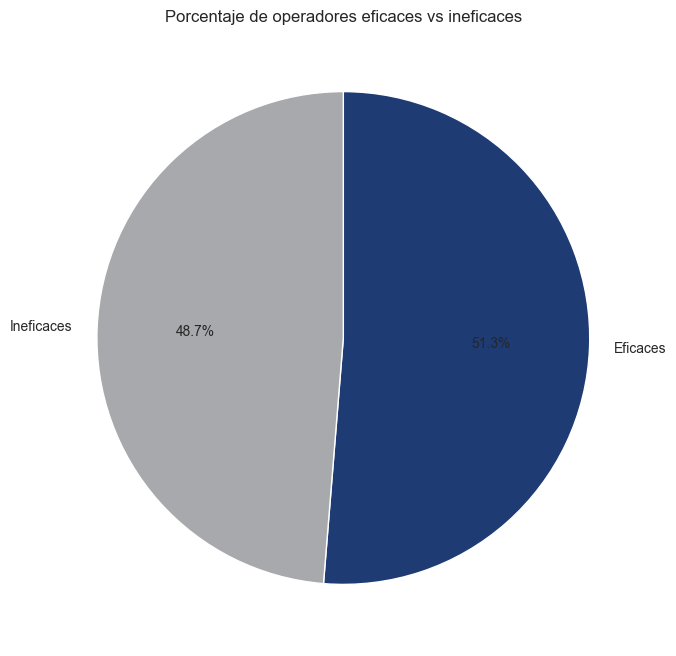

In [219]:
# Gráfico de porcentaje de eficaces vs ineficaces
eficacia_counts = operator_metrics['ineficaz'].value_counts(normalize=True) * 100

# Diccionario de etiquetas
eficacia_labels = {False: 'Eficaces', True: 'Ineficaces'}

# Gráfico circular
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(
    eficacia_counts,
    labels=[eficacia_labels[k] for k in eficacia_counts.index],
    autopct='%1.1f%%',
    colors= corporate_palette,
    startangle=90,
    counterclock=False
)
plt.title('Porcentaje de operadores eficaces vs ineficaces')
plt.show()

## Prueba de hipotesis

Hipótesis que podemos plantear:

- ¿Los operadores ineficaces tienen un tiempo de espera significativamente mayor?

- ¿Los operadores ineficaces tienen tasas de llamadas perdidas más altas?

- Test: Mann-Whitney U, ya que las distribuciones de llamadas/tiempos seguramente no son normales.



In [220]:
# Creamos dos grupos

waiting_time_eficaces = operator_metrics[operator_metrics['ineficaz']== False]['avg_waiting_time'].dropna()
waiting_time_ineficaces = operator_metrics[operator_metrics['ineficaz']== True]['avg_waiting_time'].dropna()

In [221]:

# Prueba de Mann-Whitney U 
stat, p_value_waiting = mannwhitneyu(waiting_time_eficaces, waiting_time_ineficaces, alternative='two-sided')

In [222]:
#Comparar la tasa de llamadas perdidas (missed_call_rate)
missed_rate_eficaces = operator_metrics[operator_metrics['ineficaz'] == False]['missed_call_rate'].dropna()
missed_rate_ineficaces = operator_metrics[operator_metrics['ineficaz'] == True]['missed_call_rate'].dropna()

stat2, p_value_missed = mannwhitneyu(missed_rate_eficaces, missed_rate_ineficaces, alternative='two-sided')

In [223]:
#salientes realizadas
out_calls_eficaces = operator_metrics[operator_metrics['ineficaz'] == False]['total_out_calls'].dropna()
out_calls_ineficaces = operator_metrics[operator_metrics['ineficaz'] == True]['total_out_calls'].dropna()

stat3, p_value_outcalls = mannwhitneyu(out_calls_eficaces, out_calls_ineficaces, alternative='two-sided')

In [224]:
# Resultados resumidos
resultado_pruebas = pd.DataFrame({
    'Métrica': ['Tiempo de espera promedio', 'Tasa de llamadas perdidas', 'Cantidad de llamadas salientes'],
    'p-valor': [p_value_waiting, p_value_missed, p_value_outcalls],
    '¿Diferencia significativa? (α=0.05)': ['Sí' if p < 0.05 else 'No' for p in [p_value_waiting, p_value_missed, p_value_outcalls]]
})

resultado_pruebas

,Métrica,p-valor,¿Diferencia significativa? (α=0.05)
0,Tiempo de espera promedio,2.214181e-21,Sí
1,Tasa de llamadas perdidas,4.131512e-38,Sí
2,Cantidad de llamadas salientes,1.974302e-44,Sí


# Conclusiones
1. Análisis de operadores
    - Se analizaron 53,902 registros de llamadas correspondientes a 732 cuentas de clientes.

    - Se evaluaron las llamadas entrantes, salientes, internas y externas, calculando métricas clave como:

    - Porcentaje de llamadas perdidas.

    - Tiempo de espera promedio.

    - Cantidad de llamadas salientes realizadas.

2. Identificación de operadores ineficaces
    - Se definió un operador ineficaz si cumplía al menos una de tres condiciones:

    - Alto porcentaje de llamadas entrantes perdidas.

    - Alto tiempo de espera promedio.

    - Baja cantidad de llamadas salientes realizadas.

    - Bajo estos criterios:

    - Se identificaron 532 operadores ineficaces (aproximadamente el 49% del total).

3. Resultados estadísticos
    - Se realizaron pruebas de hipótesis no paramétricas (Mann-Whitney U) para comparar operadores eficaces vs ineficaces.

Resultados:

- Tiempo de espera promedio: significativamente mayor en operadores ineficaces (p < 0.05).

- Tasa de llamadas perdidas: significativamente mayor en operadores ineficaces (p < 0.05).

- Cantidad de llamadas salientes: significativamente menor en operadores ineficaces (p < 0.05).

# Recomendaciones Ejecutivas
1. Capacitación específica
    - Implementar programas de capacitación enfocados en la reducción de tiempos de respuesta y manejo de llamadas entrantes para los operadores detectados como ineficaces.

2. Monitoreo continuo
    - Instalar un sistema de alertas tempranas que identifique operadores con:

        - Alto porcentaje de llamadas perdidas.

        - Tiempos de espera prolongados.

        - Baja productividad en llamadas salientes.

3. Incentivos por desempeño
    - Establecer bonificaciones o reconocimientos para operadores que mantengan bajos niveles de llamadas perdidas y alta eficiencia en tiempos de respuesta.

4. Ajustes de carga laboral
    - Revisar la distribución de llamadas para asegurar que los operadores ineficaces no estén sobrecargados o que no haya desbalance en la asignación de tareas.

# VINCULO PDF

https://drive.google.com/file/d/1cJBudosfaeJn5bWZZH6VRLovFkbGU3YQ/view?usp=sharing